# Inferring 1D Fourier coefficients with incomplete data coverage

_Boris Leistedt, March 2017_

This notebook is available at [this location on Github](https://github.com/ixkael/Prob-tools/blob/master/notebooks/Inferring%201D%20Fourier%20coefficients%20with%20incomplete%20data%20coverage.ipynb). 

In this notebook I will try to answer the following question: how easy is it to infer/sampling Fourier-coefficients (here, of a 1D field) when the data only covers a small portion of the domain? Since the mode coupling due to incomplete data is a linear operation, the posterior distribution should be unimodal, but might be nasty. Let's see how well we can sample it using emcee and DNest.

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from cycler import cycler

rc("font", family="serif", size=14)
rc("text", usetex=True)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['patch.linewidth'] = 2
matplotlib.rcParams['axes.prop_cycle'] =\
    cycler("color", ['k', 'c', 'm', 'y'])
matplotlib.rcParams['axes.labelsize'] = 16

import numpy as np

import dnest4
import emcee
import corner

In [2]:
# Some convenience routines

# Flattens the FFT coefficients of a real signal (which are hermitian symmetric).
def fromfft(comp, n):
    k = n // 2 + 1
    assert comp.size == k
    if n % 2 == 0:  # even
        flat = np.zeros((2*k - 2, ))
        flat[:k] = comp.real
        flat[k:] = comp.imag[1:-1]
    else:  # odd
        flat = np.zeros((2*k - 1, ))
        flat[:k] = comp.real
        flat[k:] = comp.imag[1:]
    return flat

# Recovers complex FFT coefficients given the flattened array.
def tofft(flat, n):
    k = n // 2 + 1
    comp = np.zeros((k, ), dtype=np.complex)
    comp.real = flat[:k]
    if n % 2 == 0:  # even
        assert flat.size == 2*k - 2
        comp.imag[1:-1] = flat[k:]
    else:  # odd
        assert flat.size == 2*k - 1
        comp.imag[1:] = flat[k:]
    return comp

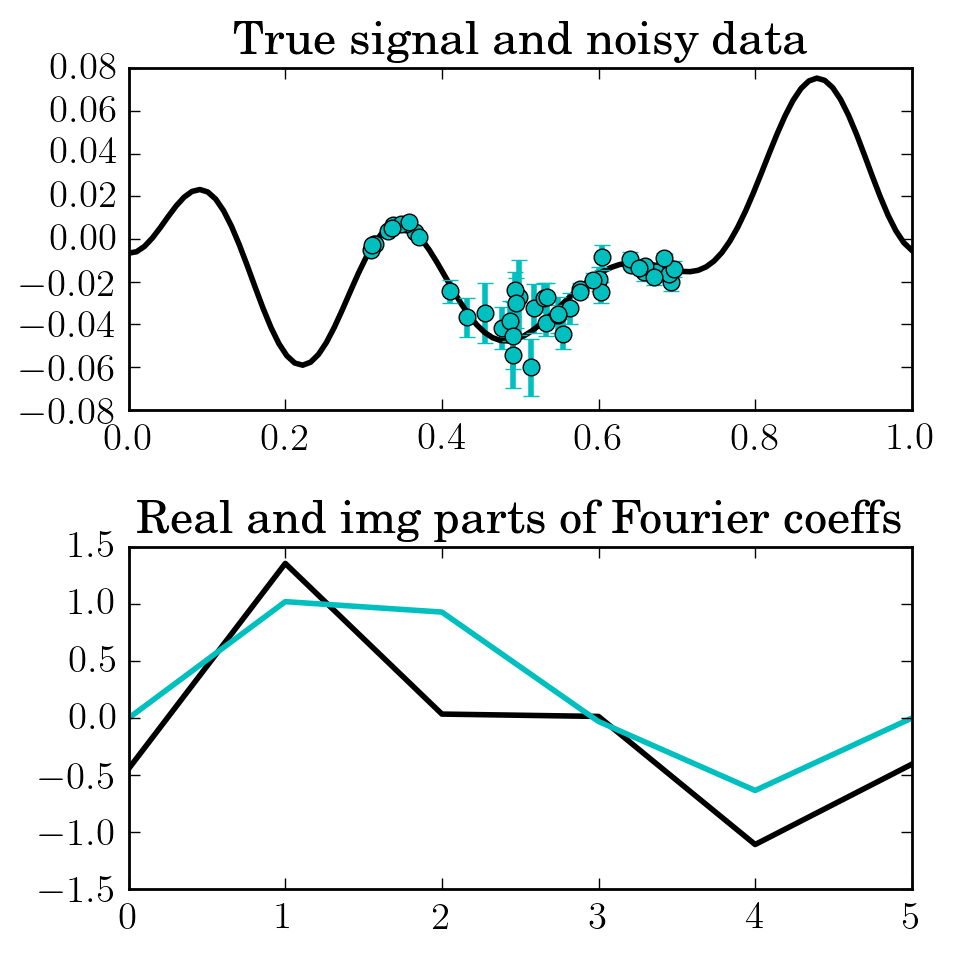

In [3]:
ndim = 10  # Number of real dimensions to generate (= ndim//2 + 1 complex fourier coefficients).
params_true = np.random.randn(ndim)  # True parameters.

nrec = 10*ndim  # High-res grid on which to reconstruct the signals.
x_grid = np.linspace(0, 1, nrec)
y_fft = tofft(params_true, ndim)  # Get FFT coefs from flat array.
y_grid = np.fft.irfft(y_fft, nrec)  # Reconstruct signal, with zero padding.

xs = np.random.uniform(0.3, 0.7, 50)  # Draw some x values in this range
ys = np.interp(xs, x_grid, y_grid)  # Get their y values
yerr = np.random.uniform(0.1, 0.4, ys.size) * ys  # Draw noise level
ys += yerr * np.random.randn(ys.size)  # Draw and add noise

# Plot the true signals and the noisy data!
fig, axs = plt.subplots(2, 1, figsize=(5, 5))
axs[0].set_title('True signal and noisy data')
axs[0].plot(x_grid, y_grid)
axs[0].errorbar(xs, ys, yerr, fmt='o')
axs[1].set_title('Real and img parts of Fourier coeffs')
axs[1].plot(y_fft.real)
axs[1].plot(y_fft.imag)
fig.tight_layout()

In [4]:
nwalkers = ndim*10

def lnprob(x, ymax, n, n2, ys, yerr):
    if np.any(np.abs(x) > ymax):
        return -np.inf
    ysm = np.interp(xs, x_grid, np.fft.irfft(tofft(x, n), n2))
    return -0.5*np.sum(((ys-ysm)/yerr)**2)

ymax = 3*np.max(np.abs(y_fft))
p0 = [np.random.uniform(-ymax, ymax, ndim) for i in range(nwalkers)]

print(lnprob(params_true, ymax, ndim, nrec, ys, yerr), lnprob(p0[0], ymax, ndim, nrec, ys, yerr))
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[ymax, ndim, nrec, ys, yerr])
pos, prob, state = sampler.run_mcmc(p0, 300)
sampler.reset()
_ = sampler.run_mcmc(pos, 1500)

-31.4939960593 -676564.1339


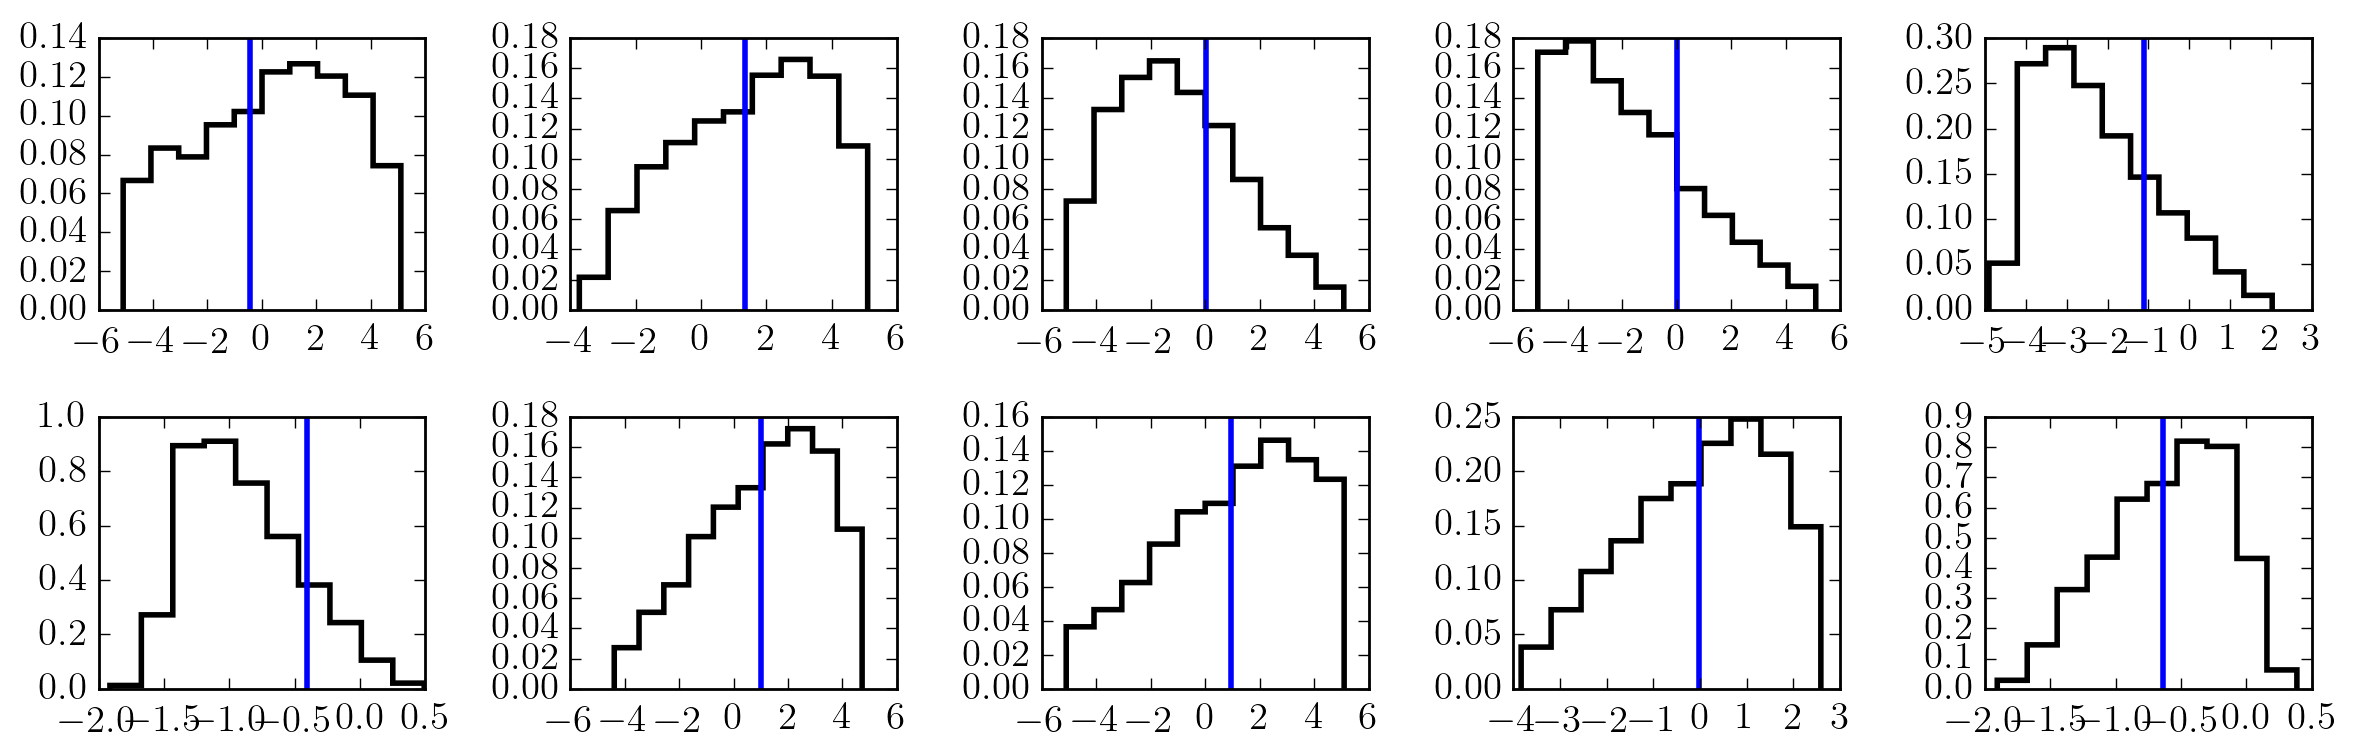

In [5]:
fig, axs = plt.subplots(2, 5, figsize=(12, 4))
axs = axs.ravel()
for i in range(ndim):
    axs[i].hist(sampler.flatchain[:, i], histtype='step', normed=True)
    axs[i].axvline(params_true[i])
fig.tight_layout()

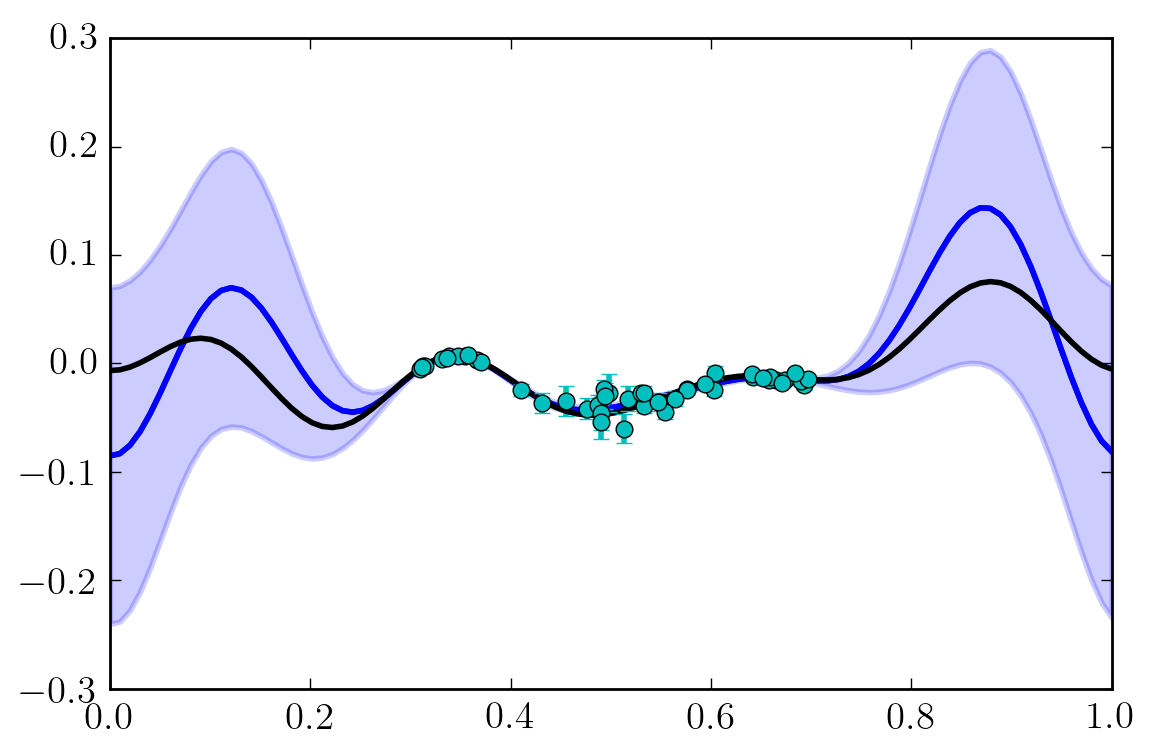

In [6]:
y_mean = 0*y_grid
y_var = 0*y_grid
nsamples = sampler.flatchain.shape[0]
for i in range(nsamples):
    y2 = np.fft.irfft(tofft(sampler.flatchain[i, :], ndim), nrec)
    y_mean += y2 / nsamples
    y_var += y2**2 / nsamples
y_var -= y_mean**2
y_std = np.sqrt(y_var)

fig, axs = plt.subplots(1, 1, figsize=(6, 4))
axs.plot(x_grid, y_mean, color='b')
axs.fill_between(x_grid, y_mean-y_std, y_mean+y_std, alpha=0.2, color='b')
axs.plot(x_grid, y_mean, color='b')
axs.plot(x_grid, y_grid)
axs.errorbar(xs, ys, yerr, fmt='o')
fig.tight_layout()

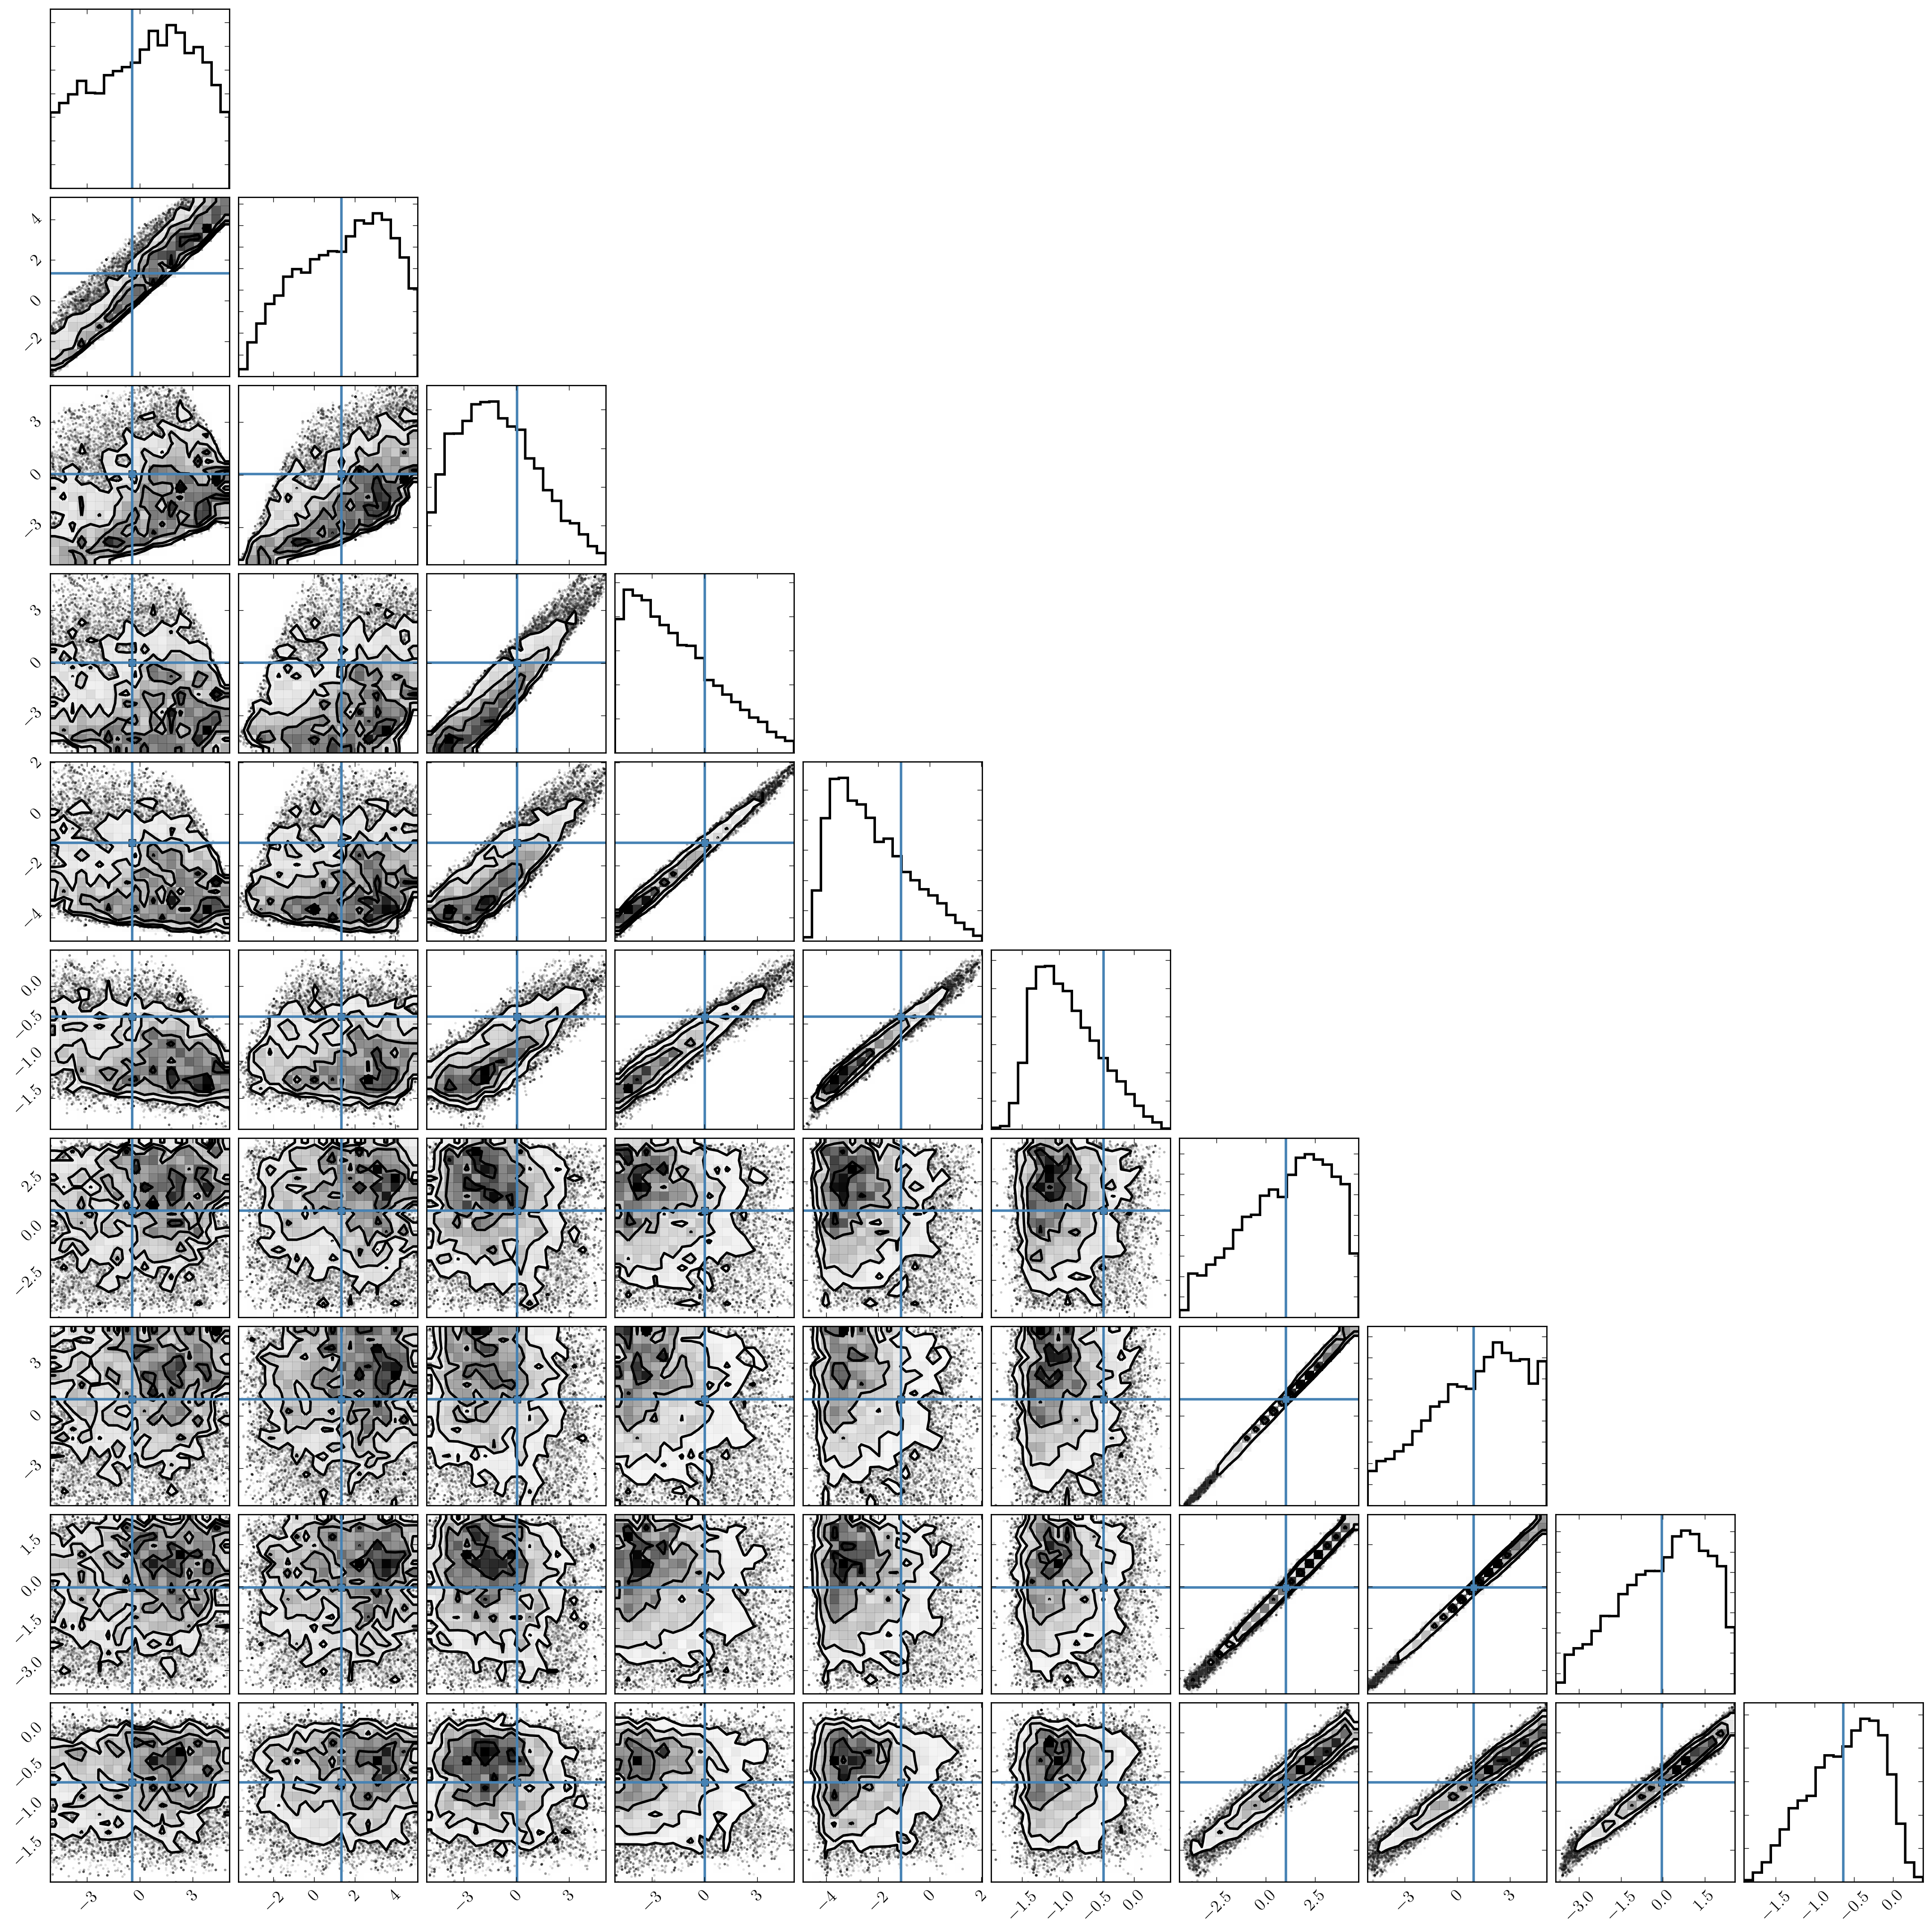

In [7]:
_ = corner.corner(sampler.flatchain, truths=params_true)

In [15]:
class Model(object):

    def __init__(self, x_grid, ymax, ndim, nrec, xs, ys, yerr):
        self.x_grid, self.ymax, self.ndim, self.nrec, self.xs, self.ys, self.yerr =\
            x_grid, ymax, ndim, nrec, xs, ys, yerr

    def from_prior(self):
        return np.random.uniform(-self.ymax, self.ymax, size=self.ndim)

    def perturb(self, coords):
        i = np.random.randint(self.ndim)
        coords[i] += 2*self.ymax*dnest4.randh()
        coords[i] = dnest4.wrap(coords[i], -self.ymax, self.ymax)
        return 0.0

    def log_likelihood(self, coords):
        fft = tofft(coords, self.ndim)
        y = np.fft.irfft(fft, self.nrec)
        ysm = np.interp(self.xs, self.x_grid, y)
        return -0.5*np.sum(((self.ys-ysm)/self.yerr)**2)

model = Model(x_grid, ymax, ndim, nrec, xs, ys, yerr)
print(model.log_likelihood(params_true))
print(model.perturb(params_true))
print(model.from_prior())
print(model.log_likelihood(model.from_prior()))
print(model.log_likelihood(model.from_prior()))

-184871.826807
0.0
[ 3.48296055 -5.07297662  3.0733068   2.55213639  3.07091578  1.28322629
  4.43298355  0.2598738   0.57375158 -4.11236467]
-501648.197533
-529058.03432


In [16]:
sampler = dnest4.DNest4Sampler(model, backend=dnest4.backends.CSVBackend(".", sep=" "))
gen = sampler.sample(max_num_levels=20, num_steps=1000, new_level_interval=10000,
                     num_per_step=10000, thread_steps=100,
                     num_particles=10, lam=10, beta=100, seed=1234)
for i, sample in enumerate(gen):
    print("# Saved {k} particles.".format(k=(i+1)))

# Saved 1 particles.
# Saved 2 particles.
# Saved 3 particles.
# Saved 4 particles.
# Saved 5 particles.
# Saved 6 particles.
# Saved 7 particles.
# Saved 8 particles.
# Saved 9 particles.
# Saved 10 particles.
# Saved 11 particles.
# Saved 12 particles.
# Saved 13 particles.
# Saved 14 particles.
# Saved 15 particles.
# Saved 16 particles.
# Saved 17 particles.
# Saved 18 particles.
# Saved 19 particles.
# Saved 20 particles.
# Saved 21 particles.
# Saved 22 particles.
# Saved 23 particles.
# Saved 24 particles.
# Saved 25 particles.
# Saved 26 particles.
# Saved 27 particles.
# Saved 28 particles.
# Saved 29 particles.
# Saved 30 particles.
# Saved 31 particles.
# Saved 32 particles.
# Saved 33 particles.
# Saved 34 particles.
# Saved 35 particles.
# Saved 36 particles.
# Saved 37 particles.
# Saved 38 particles.
# Saved 39 particles.
# Saved 40 particles.
# Saved 41 particles.
# Saved 42 particles.
# Saved 43 particles.
# Saved 44 particles.
# Saved 45 particles.
# Saved 46 particle

log(Z) = -100.920681985
Information = 23.0747024389 nats.
Effective sample size = 1.00000000064


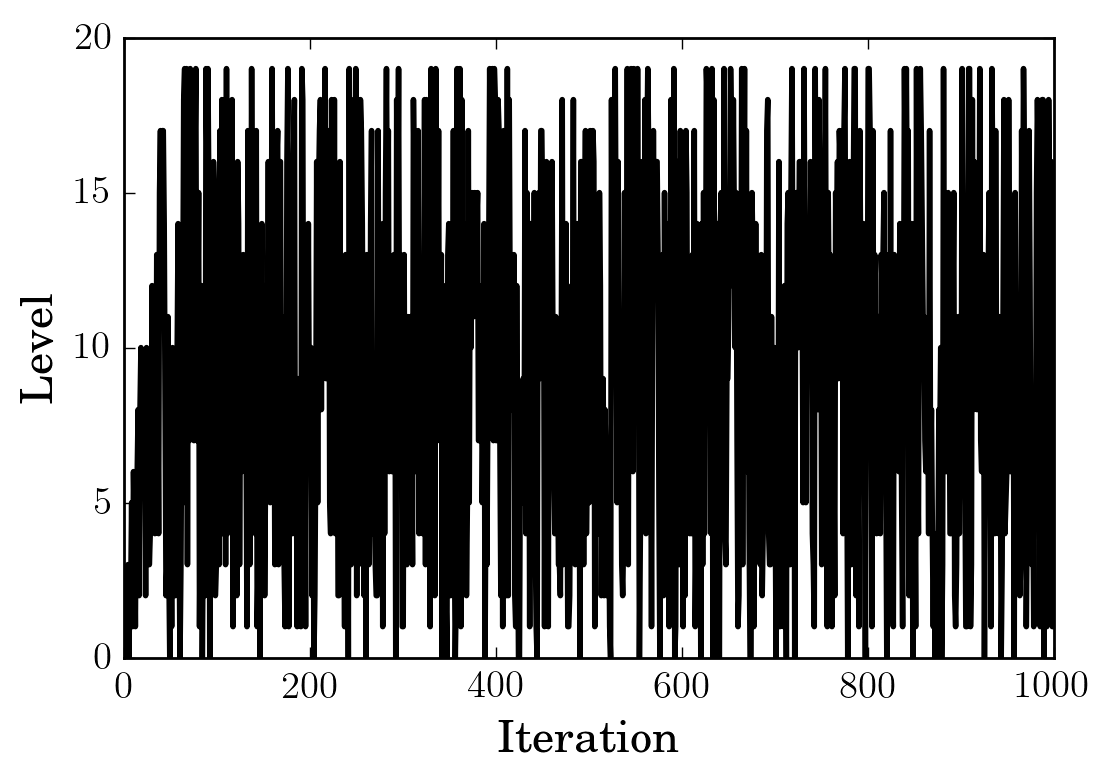

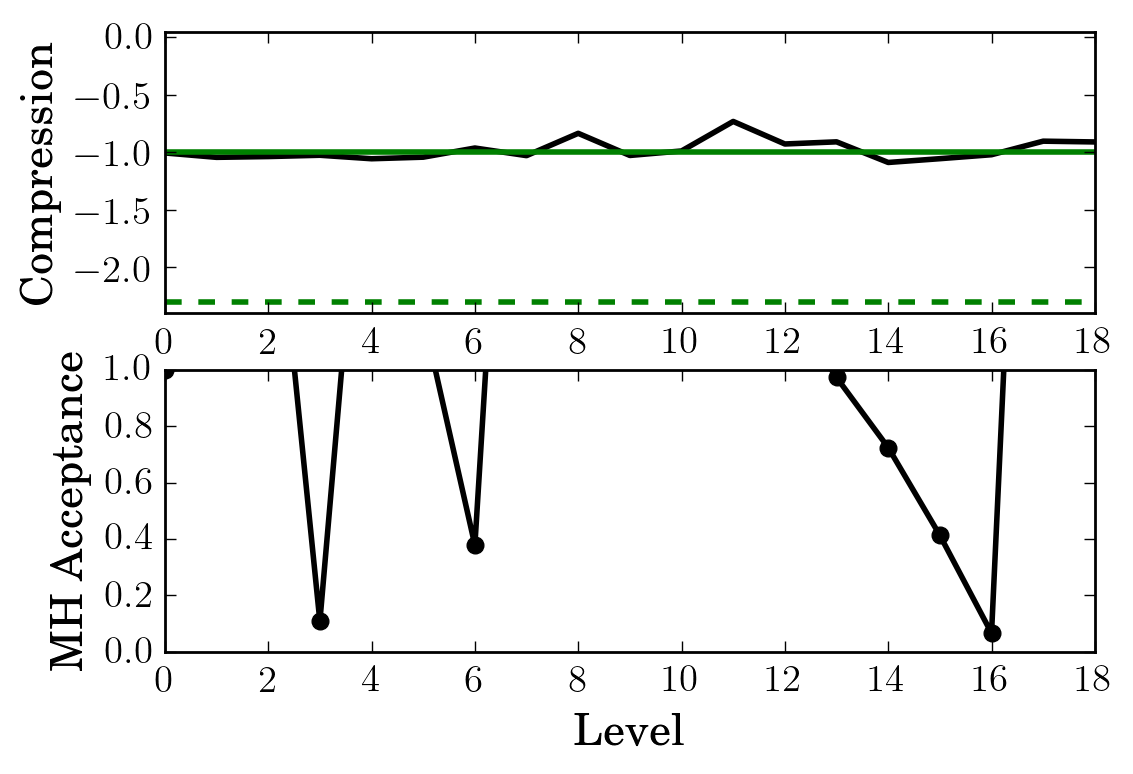

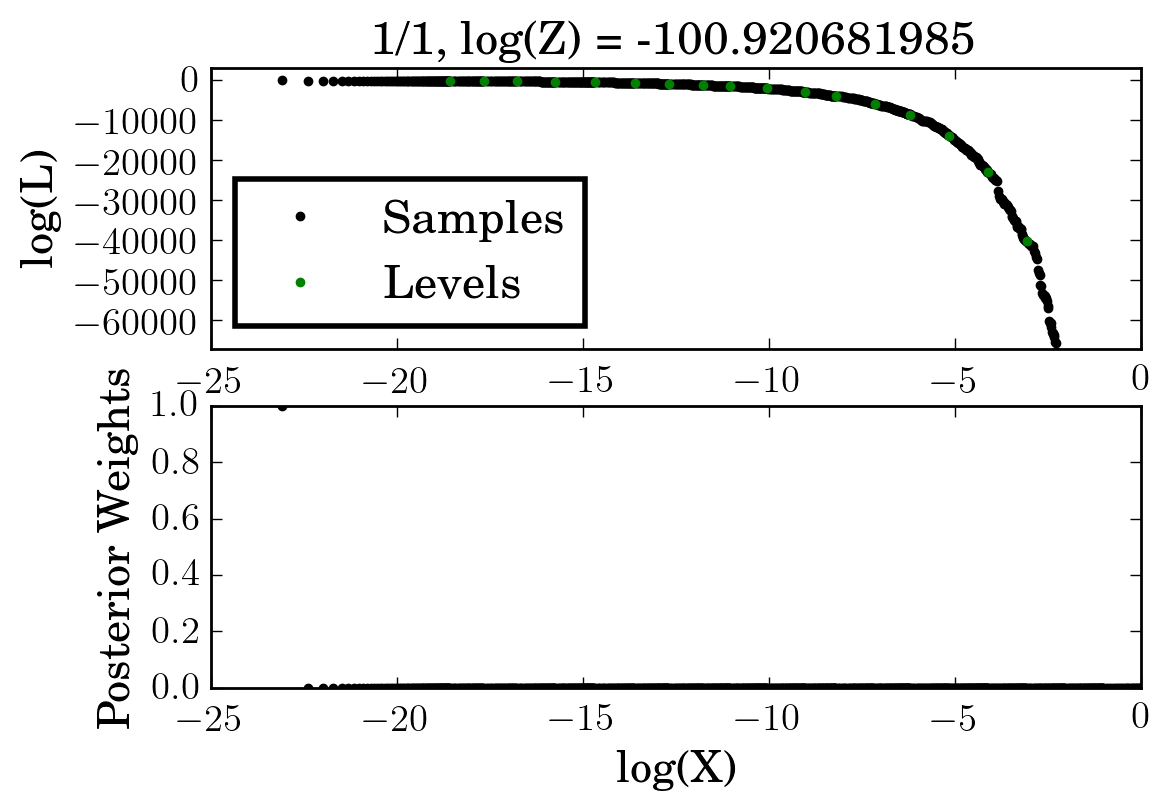

In [17]:
stats = dnest4.postprocess()

In [18]:
flatchain = np.genfromtxt('posterior_sample.txt')
print(flatchain.shape)

(10,)


In [ ]:
fig, axs = plt.subplots(ndim, ndim, figsize=(12, 12))
for i in range(ndim):
    axs[i, i].hist(flatchain[:, i], histtype='step', normed=True, range=[-ymax, ymax])
    axs[i, i].set_yticklabels([])
    axs[i, i].set_xticklabels([])
    axs[i, i].axvline(params_true[i], lw=1)
    for j in range(i):
        if i < ndim - 1:
            axs[i, j].set_xticklabels([])
        if j > 0:
            axs[i, j].set_yticklabels([])
        axs[i, j].hist2d(flatchain[:, i], flatchain[:, j], 12,
                      range=[[-ymax, ymax], [-ymax, ymax]], cmap="Greys")
        axs[i, j].axvline(params_true[i], color='b', lw=1)
        axs[i, j].axhline(params_true[j], color='b', lw=1)
        plt.delaxes(axs[j, i])
fig.tight_layout()